<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/!HW_10_ensemble_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK: Train classifiers on the dataset https://archive.ics.uci.edu/dataset/713/auction+verification**

There should be 3 classifier variants (stacking, boosting, bagging)

Mandatory steps:

1. Initial data analysis (missing values, presence of categorical features, ...)
2. Feature engineering (create 1-2 new features)
3. Feature scaling
4. Split the dataset into training, validation, and test samples
5. Train a base model with default hyperparameters
6. Hyperparameter tuning
7. Evaluate the results

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the dataset**

In [ ]:
# Завантажимо наш датасет
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv")
df.columns = df.columns.str.replace(".", "_", regex=True)
df.head()

,process_b1_capacity,process_b2_capacity,process_b3_capacity,process_b4_capacity,property_price,property_product,property_winner,verification_result,verification_time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


**Let's take a look at the information for all columns**

In [ ]:
# Дивимось інформацію по всіх колонках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process_b1_capacity  2043 non-null   int64  
 1   process_b2_capacity  2043 non-null   int64  
 2   process_b3_capacity  2043 non-null   int64  
 3   process_b4_capacity  2043 non-null   int64  
 4   property_price       2043 non-null   int64  
 5   property_product     2043 non-null   int64  
 6   property_winner      2043 non-null   int64  
 7   verification_result  2043 non-null   bool   
 8   verification_time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


**We see that there are no missing values or categorical features. Apart from numerical columns, we have one boolean column, which is clearly the target variable in this dataset**

In [ ]:
# Бачимо, що пропущених значень та категоріальних  фіч немає,
# маємо окрім числових одну колонку булеву, очевидно, що в даному датасеті це і є наш таргет

**Let's separate the numerical columns for convenience**

In [ ]:
# Відокремимо наші числові колонки для зручності
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns

**Let's take another look at the data description**

In [ ]:
# Подивимось ще опис даних
df.describe()

,process_b1_capacity,process_b2_capacity,process_b3_capacity,process_b4_capacity,property_price,property_product,property_winner,verification_time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,10876.638889
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000,44130.520833


**We can notice some anomalies in the 'verification_time' column; the maximum value is quite large, suggesting the presence of outliers**

In [ ]:
# Можна помітити деякі ознаки аномалій в колонці verification_time, максимальне значення є достатньо великим,
# тож можна припустити, що присутні аутлеєри

**Let's take a closer look**

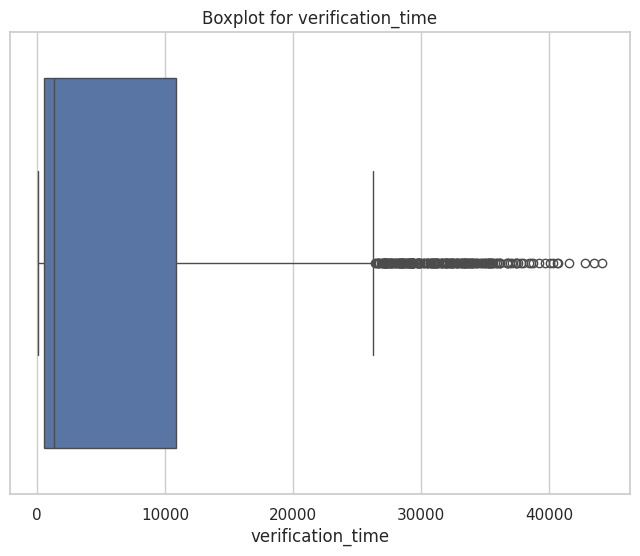

In [ ]:
# Подивимось трохи детальніше:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["verification_time"])
plt.title("Boxplot for verification_time")

plt.show()

**The assumption is correct: we can see many anomalous values. We understand that all values around 26,000 and above are outliers**

In [ ]:
# Припущення вірне, бачимо багатенько аномальних значень. Розуміємо, що всі значення приблизно від 26 тис і вище - аутлеєри

**Let's calculate them as a percentage**

In [ ]:
# Порахуємо їх у відсотках
Q1 = df["verification_time"].quantile(0.25)
Q3 = df["verification_time"].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["verification_time"] < lower_bound) | (df["verification_time"] > upper_bound)]
percentage_outliers = (len(outliers) / len(df)) * 100
print(percentage_outliers)

10.083210964268233


**We see that the percentage of outliers in the 'verification_time' column is 10%, which is quite high. However, before deciding what to do with them, we need to look at the distribution of classes**

In [ ]:
# Бачимо, що відсоток аутлеєрів у колонці verification_time 10%, досить багато. Та перш ніж вирішувати, що з ними робити,
# треба подивитися який у нас розподіл класів

**Let's plot the distribution of the target variable**

<Axes: xlabel='verification_result', ylabel='count'>

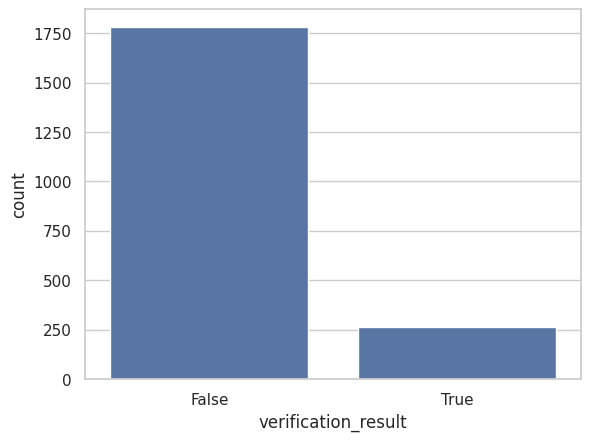

In [ ]:
# Побудуємо графік розподілу таргету:
sns.countplot(data=df, x="verification_result")

**Let's take a look at the numerical values**

In [ ]:
# Дивимось додатково значення в числах
df.verification_result.value_counts()

False    1781
True      262
Name: verification_result, dtype: int64

**We see that there are more 'False' values than 'True' values by almost 7 times, indicating a class disbalance. We need to understand in which class there are more outliers in the 'verification_time' column because if it's in the 'True' class, we cannot simply delete them due to the existing disbalance. So, let's check**

<Figure size 1000x800 with 0 Axes>

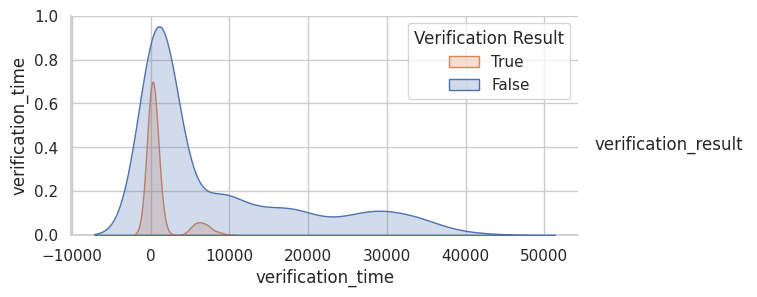

In [ ]:
# Бачимо, що значень False більше ніж значень True майже в 7 разів, а значить ми маємо дизбаланс класів.
# Треба розуміти, в якому класі більше аутлеєрів по колонці verification_time,
# бо якщо в True, то видаляти їх не можна, так як і так маємо дисбаланс
# Тож перевіряємо
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue="verification_result", vars=["verification_time"], height=3, aspect=2)
plt.legend(title="Verification Result", loc="upper right", labels=["True", "False"])
plt.show()

**We see that according to the distribution, values above 26,000 belong to the 'False' class, so we can delete these outliers**

In [ ]:
# Бачимо, що згідно з розподілом, значення більше 26 тис має клас False, тож можемо видалити ці аутлеєри
Q1 = df["verification_time"].quantile(0.25)
Q3 = df["verification_time"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cleaned = df[(df["verification_time"] >= lower_bound) & (df["verification_time"] <= upper_bound)]

**Let's verify if we correctly understood the previous graph**

In [ ]:
# Перевіряємо, чи правильно ми зрозуміли попередній графік
df_cleaned.verification_result.value_counts()

False    1575
True      262
Name: verification_result, dtype: int64

**Yes, everything is fine; all values of the 'True' class remain unchanged**

In [ ]:
# Так, все добре, всі значення класу True залишились на місці.

**Let's build a scatter plot matrix to examine the distribution and correlation between features**

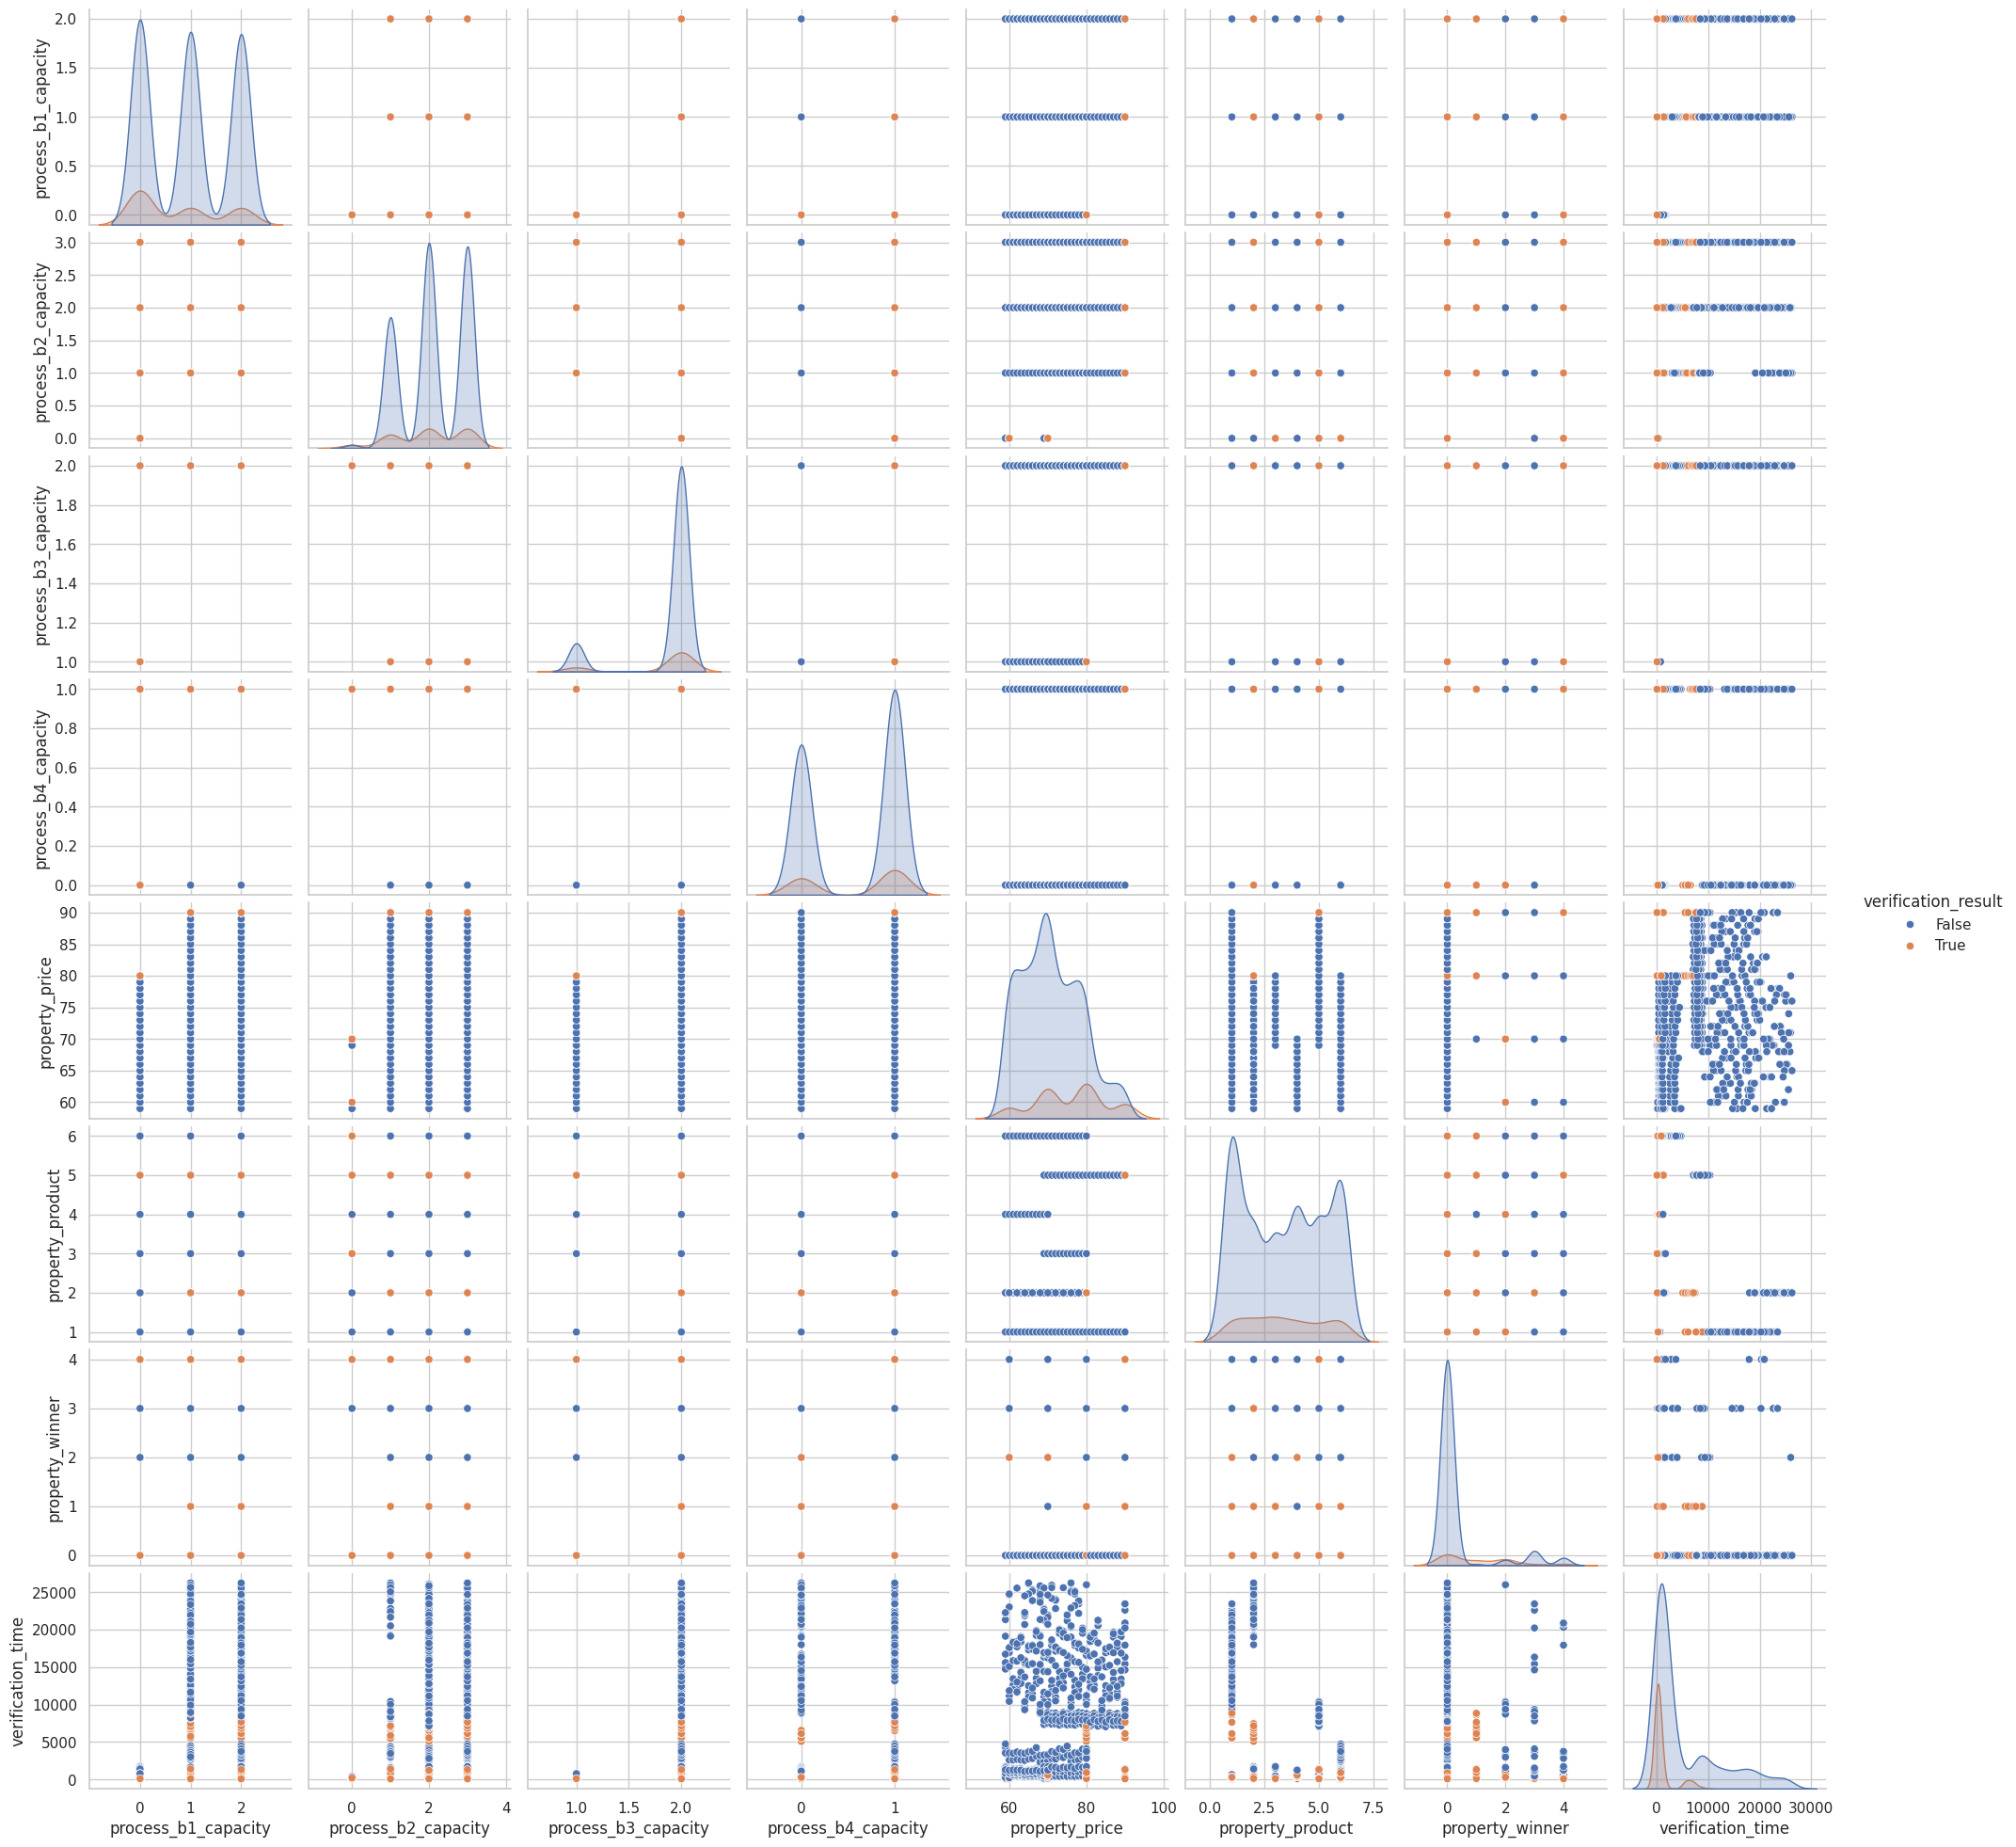

In [ ]:
# Побудуємо матрицю розсіювання, подивимось на розподіл і взаємозв'язки між фічами.
sns.pairplot(df_cleaned, hue="verification_result")
plt.grid(True)
plt.show()

**We can see that many features have similar values (e.g., 'process_capacity'), but their distribution for True and False is different. In addition, we can clearly see that there is very little data for the True class**

In [ ]:
# Бачимо, що значення по багатьом фічам однакові (напр.process_capasity), але їх розподіл для True та False різний.
# Окрім того дуже добре видно, що даних по класу True дуже мало.

**Let's take a look at the unique values of the features**

In [ ]:
# Подивимось ще на унікальні значення фіч
for column in numeric_columns:
    unique_values = df_cleaned[column].unique()
    print(f"Unique values in column {column}:\n{unique_values}\n")

Unique values in column process_b1_capacity:
[0 1 2]

Unique values in column process_b2_capacity:
[0 1 2 3]

Unique values in column process_b3_capacity:
[2 1]

Unique values in column process_b4_capacity:
[1 0]

Unique values in column property_price:
[59 60 69 70 61 62 63 64 65 66 67 68 71 72 73 74 75 76 77 78 79 80 81 82
 83 84 85 86 87 88 89 90]

Unique values in column property_product:
[1 2 4 6 3 5]

Unique values in column property_winner:
[0 3 4 2 1]

Unique values in column verification_time:
[ 163.31666667  200.86        154.88888889 ... 9365.45       8474.025
   82.00833333]



**We see that indeed the 'process_capacity' columns contain identical elements; for example, the value '1' appears in all four columns, but they are combined differently. It can be said that the 'process_b2_capacity' column has the widest variety of values, which is also evident from the graph above**

In [ ]:
# Бачимо, що дійсно колонки process_capacity містять однакові елементи, наприклад 1 є у всіх 4х колонках, але вони по різному поєднуються.
# Можна сказати, що найбільший різновид значень містить колонка process_b2_capacity, що в принципі, видно й на графіку вище

**Let's take a look at the difference in mean values between the classes**

In [ ]:
# Подивимось ще на різницю середніх значеннь між класами
df_cleaned[numeric_columns].groupby(df_cleaned["verification_result"]).mean()

,process_b1_capacity,process_b2_capacity,process_b3_capacity,process_b4_capacity,property_price,property_product,property_winner,verification_time
verification_result,,,,,,,,
False,0.975238,2.118095,1.878730,0.577143,70.892698,3.387302,0.363810,5176.404270
True,0.744275,2.000000,1.824427,0.599237,75.916031,3.423664,1.049618,1060.181647


**Once again, by the 'verification_time' column: the average value for the 'False' class is significantly higher than the average for the 'True' class. Therefore, we can conclude that there is a potentially important difference between the classes. Additionally, we can also note the 'property_winner' column. So these two features are quite good for classifying positive and negative decisions**

In [ ]:
# Знову привертає увагу колонка verification_time: середнє значення класу False значно вище середнього значення True.
# Тож можна зробити висновок, що між нашими класами є потенційно важлива різниця.
# Також можна відмітити й колонку property_winner. Тож саме ці дві фічі досить непогані для класифікації позитивного і негативного рішень.

**Let's consider the correlation matrix**

<Axes: >

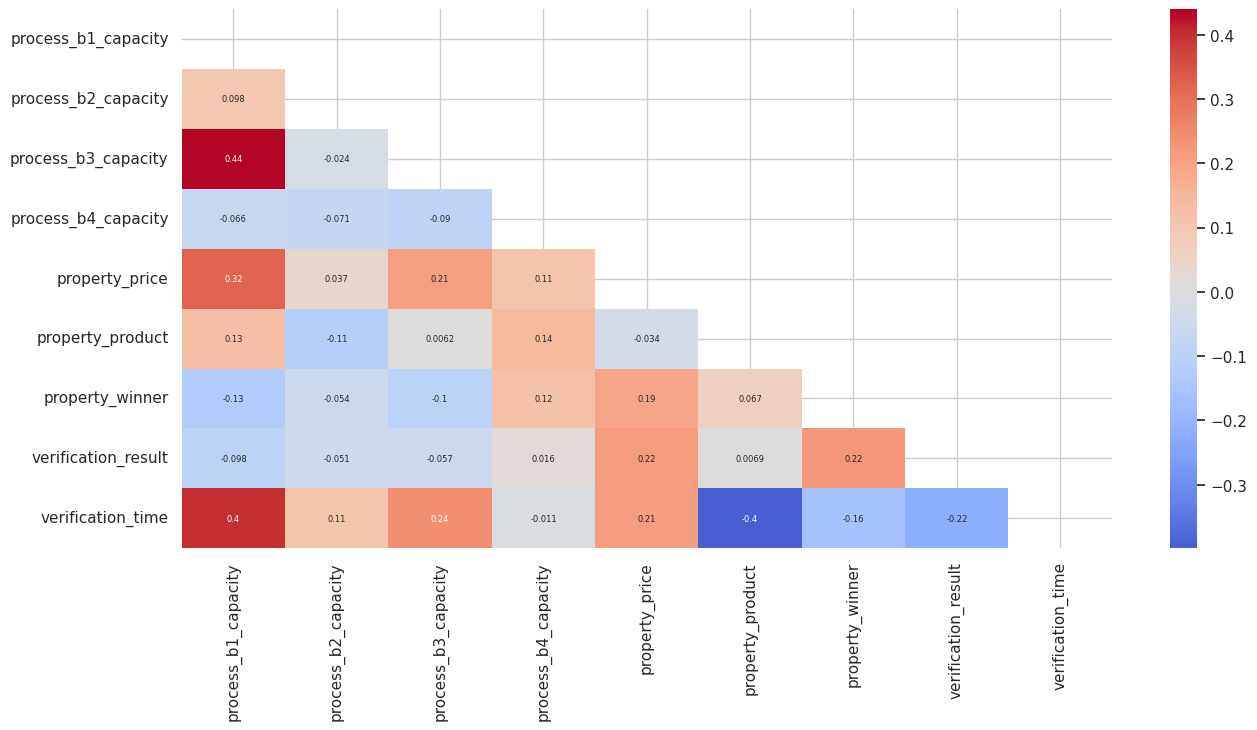

In [ ]:
# Розглянемо матрицю кореляцій
corr_df = df_cleaned.corr()
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**The highest correlation is 0.44 and 0.4, which is not critical**

In [ ]:
# Найбільший зв'язок має значення 0.44 і 0.4, не критично

**Adding new features**

In [ ]:
# Додаємо нові фічі

**The 1st feature - the total capacity of the processes**

In [ ]:
# Рахуємо загальну ємність процесів
df_cleaned.insert(0, "total_process_capacity", df_cleaned["process_b1_capacity"] + df_cleaned["process_b2_capacity"] + df_cleaned["process_b3_capacity"] + df_cleaned["process_b4_capacity"])

**The 2nd feature - the average capacity value of the processes**

In [ ]:
# Рахуємо середнє значення ємності процесів
df_cleaned.insert(0, "average_proc_capacity", df_cleaned[["process_b1_capacity", "process_b2_capacity", "process_b3_capacity", "process_b4_capacity"]].mean(axis=1))

**The 3rd feature - the average verification time per process capacity**

In [ ]:
# Рахуємо середній час верифікації по ємності процесів
df_cleaned.insert(0, "average_verification_time", df_cleaned["verification_time"] / df_cleaned["total_process_capacity"])

**The 4th feature - the winner-to-product ratio**

In [ ]:
# Рахуємо співвідношення переможця до продукту
df_cleaned.insert(0, "winner_to_product_ratio", df_cleaned["property_winner"] / df_cleaned["property_product"])

**Let's see how the correlation matrix has changed**

<Axes: >

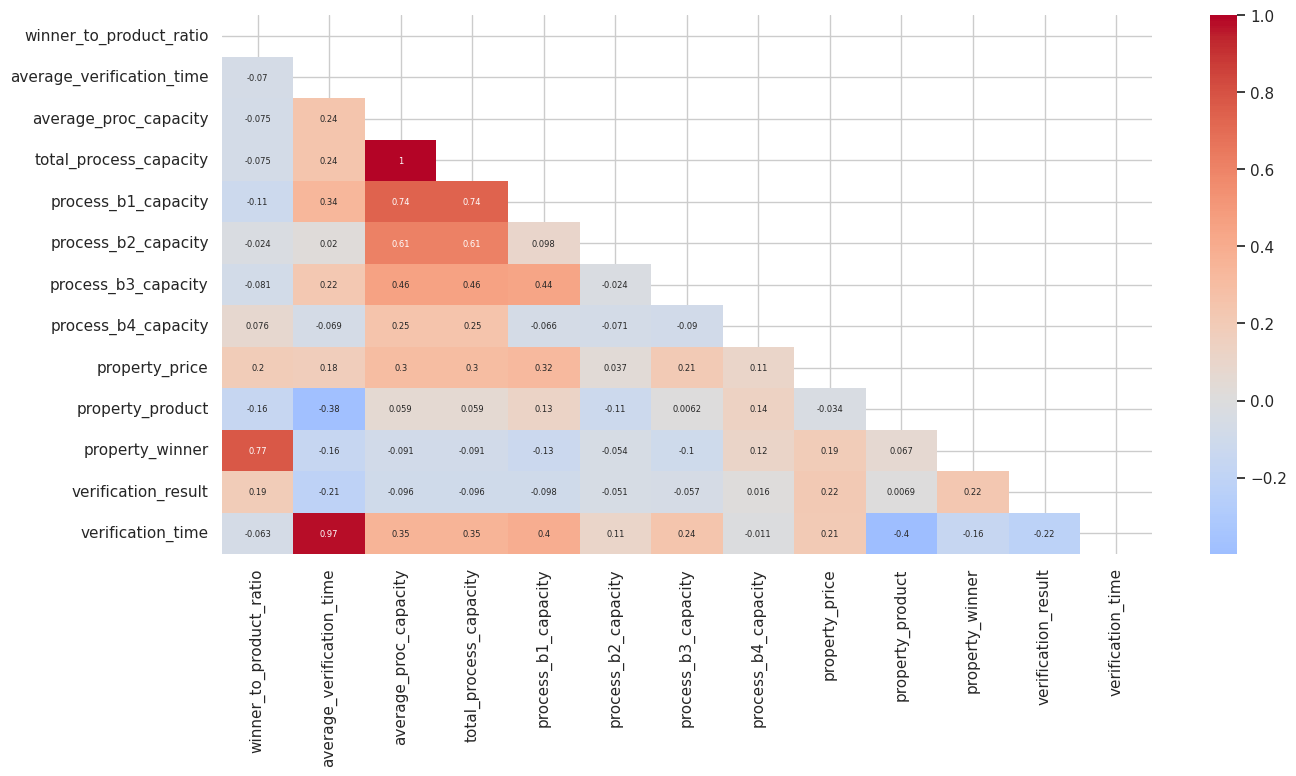

In [ ]:
# Подивимось як змінилась матриця кореляцій
corr_df = df_cleaned.corr()
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**We have 2 high correlations with indicators of 1 and 0.97, while the rest show a completely normal picture, so we won't delete anything**

In [ ]:
# Маєм 2 високих зв'язки зі показниками 1 і 0.97, по іншим картина абсолютно нормальна, тож не будем нічого видаляти

**Let's take a look at the correlations with the target**

In [ ]:
# Подивимось окремо кореляції з нашим таргетом
corr_with_target = df_cleaned.corr().verification_result.sort_values(ascending=False, key = lambda x: abs(x)).to_frame()
corr_with_target.drop("verification_result")

,verification_result
property_winner,0.224807
verification_time,-0.218962
property_price,0.215980
average_verification_time,-0.213310
winner_to_product_ratio,0.190572
process_b1_capacity,-0.097914
average_proc_capacity,-0.096463
total_process_capacity,-0.096463
process_b3_capacity,-0.056647
process_b2_capacity,-0.051070


**We see that there are no issues with correlation here at all; the values are not even close to the averages. So, let's proceed to model creation.**

In [ ]:
# Бачимо, що тут проблем з кореляцією немає взагалі, значення навіть не близькі до середніх. Тож переходимо до створення моделей

**Splitting the dataset into a feature matrix**

In [ ]:
# Розділяємо датасет на матрицю фіч
X = df_cleaned.drop("verification_result", axis=1)
y = df_cleaned["verification_result"]

**Scaling the features**

In [ ]:
# Масштабуємо фічі
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Splitting the dataset into training, validation, and test samples**

In [ ]:
# Розділяємо датасет на тренувальну, валідаційну та тестову частини
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

**Creating Random Forest model**

In [ ]:
# Почнемо з моделі Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

# print the scores:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores RF-Model:", cv_scores)
print("Train Score RF-Model:", train_score)
print("Test Score RF-Model:", test_score)

Cross-Validation Scores RF-Model: [0.9922179  0.98832685 0.97276265 0.9922179  0.9922179 ]
Train Score RF-Model: 1.0
Test Score RF-Model: 0.9855072463768116


**The metrics are high, and the difference between the training and test data is very small. It can be said that the model generalizes the data well.**

In [ ]:
# Показники високі, різниця між тренувальними та тестовими даними дуже маленька, можна сказати, що модель добре узагальнює дані

**Hyperparameters for Random Forest**

In [ ]:
# tuning hyperparameters for Random Forest:
# Підбираємо гіперпараметри для Random Forest
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")
grid_search_rf.fit(X_val, y_val)

# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_rf_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_
print("Best RF Parameters:", best_rf_params)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_rf_accuracy = best_rf_model.score(X_val, y_val)
print("Validation RF Accuracy:", valid_rf_accuracy)

Best RF Parameters: {'max_depth': None, 'n_estimators': 50}
Validation RF Accuracy: 1.0


**Creating LogisticRegression model**

In [ ]:
# Створюємо модель LogisticRegression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

# print the scores:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores LR-Model:", cv_scores)
print("Train Score LR-Model:", train_score)
print("Test Score LR-Model:", test_score)

Cross-Validation Scores LR-Model: [0.89105058 0.89105058 0.88326848 0.89105058 0.86381323]
Train Score LR-Model: 0.8824902723735408
Test Score LR-Model: 0.8514492753623188


**Here the situation is slightly worse, but it still looks good.**

In [ ]:
# Тут картина трошки гірша, але виглядає теж непогано

**Hyperparameters for LogisticRegression**

In [ ]:
# tuning hyperparameters for LogisticRegression:
# Підбираємо гіперпараметри для LogisticRegression
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [50, 100, 200],
    "class_weight": [None, "balanced"]
}

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=3)
grid_search_lr.fit(X_val, y_val)

# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_lr_params = grid_search_lr.best_params_
best_lr_model = grid_search_lr.best_estimator_
print("Best LR Parameters:", best_lr_params)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_accuracy_lr = best_lr_model.score(X_val, y_val)
print("Validation LR Accuracy:", valid_accuracy_lr)


Best LR Parameters: {'C': 10, 'class_weight': None, 'max_iter': 50}
Validation LR Accuracy: 0.8985507246376812


**Creating K-Nearest Neighbors model**

In [ ]:
# Створюємо метричну модель (K-Nearest Neighbors)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = knn_model.score(X_train, y_train)
test_score = knn_model.score(X_test, y_test)

# print the scores:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores KNN-Model:", cv_scores)
print("Train Score KNN-Model:", train_score)
print("Test Score KNN-Model:", test_score)

Cross-Validation Scores KNN-Model: [0.89494163 0.87159533 0.87159533 0.87548638 0.89494163]
Train Score KNN-Model: 0.91284046692607
Test Score KNN-Model: 0.8840579710144928


**So, we see that K-Nearest Neighbors also has a quite good result, slightly better than LogisticRegression.**

In [ ]:
# Отже, бачимо, що K-Nearest Neighbors має також досить гарний результат, трохи краще ніж LogisticRegression

**Hyperparameters for K-Nearest Neighbors**

In [ ]:
# tuning hyperparameters for K-Nearest Neighbors:
# Підбираємо гіперпараметри для K-Nearest Neighbors
param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=3)
grid_search_knn.fit(X_val, y_val)

# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_params = grid_search_knn.best_params_
best_knn_model = grid_search_knn.best_estimator_
print("Best KNN Parameters:", best_params)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_accuracy_knn = best_knn_model.score(X_val, y_val)
print("Validation KNN Accuracy:", valid_accuracy_knn)

Best KNN Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Validation KNN Accuracy: 0.9311594202898551


**Creating and training a Bagging model**

In [ ]:
# Тренуємо модель Bagging
bagging_model = BaggingClassifier(estimator=rf_model, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
train_score_bag = bagging_model.score(X_train, y_train)
test_score_bag = bagging_model.score(X_test, y_test)

print("Train Score GB-Model:", train_score_bag)
print("Test Score GB-Model:", test_score_bag)

Train Score GB-Model: 0.9992217898832685
Test Score GB-Model: 0.9746376811594203


**Creating and training a Gradient Boosting**

In [ ]:
# Робимо тренування моделей бустинга (Gradient Boosting)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

train_score_gb = gb_model.score(X_train, y_train)
test_score_gb = gb_model.score(X_test, y_test)

print("Train Score GB-Model:", train_score_gb)
print("Test Score GB-Model:", test_score_gb)

Train Score GB-Model: 1.0
Test Score GB-Model: 0.9891304347826086


**Hyperparameters for Gradient Boosting**

In [ ]:
# tuning hyperparameters for Gradient Boosting
# Підбираємо гіперпараметри для Gradient Boosting
param_grid_gb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [3, 5, 10]
    }

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring="accuracy")
grid_search_gb.fit(X_val, y_val)

# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_gb_params = grid_search_gb.best_params_
best_gb_model = grid_search_gb.best_estimator_
print("Best RF Parameters:", best_gb_params)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_accuracy_gb = best_gb_model.score(X_val, y_val)
print("Validation Accuracy:", valid_accuracy_gb)

Best RF Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Validation Accuracy: 0.9963768115942029


**Creating and training a StackingClassifier model**

In [ ]:
# We take the best models Random Forest, K-Nearest Neighbors, and Logistic Regression for the training:
# Тренування моделі стекінга. Беремо кращі моделі Random Forest, K-Nearest Neighbors та Logistic Regression
stacking_model = StackingClassifier(estimators=[("rf", best_rf_model), ("knn", best_knn_model)], final_estimator=best_lr_model)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

# Evaluation of accuracy results for the default and improved models:
# Оцінка результатів accuracy по дефолтним і кращим моделям
print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Best Random Forest Accuracy: {valid_rf_accuracy}")

print(f"Logistic Regression Accuracy: {accuracy_lr}")
print(f"Best Logistic Regression  Accuracy: {valid_accuracy_lr}")

print(f"K-Nearest Neighbors: {accuracy_knn}")
print(f"Best K-Nearest Neighbors  Accuracy: {valid_accuracy_knn}")

print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print(f"Best Gradient Boosting Accuracy: {valid_accuracy_gb}")
print(f"Bagging Accuracy: {accuracy_bagging}")
print(f"Stacking Accuracy: {accuracy_stacking}")

Random Forest Accuracy: 0.9855072463768116
Best Random Forest Accuracy: 1.0
Logistic Regression Accuracy: 0.8514492753623188
Best Logistic Regression  Accuracy: 0.8985507246376812
K-Nearest Neighbors: 0.8840579710144928
Best K-Nearest Neighbors  Accuracy: 0.9311594202898551
Gradient Boosting Accuracy: 0.9891304347826086
Best Gradient Boosting Accuracy: 0.9963768115942029
Bagging Accuracy: 0.9746376811594203
Stacking Accuracy: 0.9855072463768116


**It can be noted that hyperparameter tuning for each model slightly improved the results, especially noticeable in Logistic Regression and K-Nearest Neighbors. Based on accuracy scores, the highest performance is observed in the Best Random Forest, followed by the Best Gradient Boosting. However, due to class disbalance, it's important to consider all metrics. Therefore, we generate a Classification Report for each model.**

In [ ]:
# Можна відмітити, що підбір гіперпараметрів по кожній моделі трохи покращив результати,
# особливо це видно по показникам Logistic Regression та K-Nearest Neighbors.
# По оцінкам accuracy найвищий показник в Best Random Forest, далі йде Best Gradient Boosting.
# Але так як маємо дисбаланс класів, варто подивитися всі оцінки. Тож робимо Classification Report на кожну модель

In [ ]:
report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest:")
print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(report_rf)

Random Forest:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       233
        True       1.00      0.91      0.95        43

    accuracy                           0.99       276
   macro avg       0.99      0.95      0.97       276
weighted avg       0.99      0.99      0.99       276



In [ ]:
report_lr = classification_report(y_test, y_pred_lr)
print("LogisticRegression:")
print(f"Accuracy: {accuracy_lr:.2f}")
print("Classification Report:")
print(report_lr)

LogisticRegression:
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.98      0.92       233
        True       0.58      0.16      0.25        43

    accuracy                           0.85       276
   macro avg       0.72      0.57      0.59       276
weighted avg       0.82      0.85      0.81       276



In [ ]:
report_knn = classification_report(y_test, y_pred_knn)
print("K-Nearest Neighbors:")
print(f"Accuracy: {accuracy_knn:.2f}")
print("Classification Report:")
print(report_knn)

K-Nearest Neighbors:
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.98      0.93       233
        True       0.76      0.37      0.50        43

    accuracy                           0.88       276
   macro avg       0.83      0.68      0.72       276
weighted avg       0.87      0.88      0.87       276



In [ ]:
report_bagging = classification_report(y_test, y_pred_bagging)
print("Bagging:")
print(f"Accuracy: {accuracy_bagging:.2f}")
print("Classification Report:")
print(report_bagging)

Bagging:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.99       233
        True       0.97      0.86      0.91        43

    accuracy                           0.97       276
   macro avg       0.97      0.93      0.95       276
weighted avg       0.97      0.97      0.97       276



In [ ]:
report_boosting = classification_report(y_test, y_pred_gb)
print("Boosting:")
print(f"Accuracy: {accuracy_gb:.2f}")
print("Classification Report:")
print(report_boosting)

Boosting:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       233
        True       1.00      0.93      0.96        43

    accuracy                           0.99       276
   macro avg       0.99      0.97      0.98       276
weighted avg       0.99      0.99      0.99       276



In [ ]:
report_stacking = classification_report(y_test, y_pred_stacking)
print("Stacking:")
print(f"Accuracy: {accuracy_stacking:.2f}")
print("Classification Report:")
print(report_stacking)

Stacking:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       233
        True       1.00      0.91      0.95        43

    accuracy                           0.99       276
   macro avg       0.99      0.95      0.97       276
weighted avg       0.99      0.99      0.99       276



**Well, we conclude that despite a fairly high level of accuracy, the LogisticRegression and K-Nearest Neighbors models show good results only for the False class. The lowest precision score (0.58) for the True class indicates that only 58% of objects predicted as True by the LogisticRegression model are actually True, and a recall of 0.16 suggests that the model may miss many true objects of the class. Therefore, in this case, the worst-performing model is LogisticRegression. As for the best classifier, it is Gradient Boosting, which has the highest scores for both classes.**

In [ ]:
# Що ж, робимо висновок, що не дивлячись на достатньо високий рівень accuracy, моделі LogisticRegression та K-Nearest Neighbors
# показують непогані результати тільки на класі False. Найнижчі показники precision (0.58) по класу True говорять про те,
# що тільки 58% об'єктів, передбачених моделлю LogisticRegression як True, справді є True,
# а recall 0.16 свідчить про те, що модель може упускати безліч справжніх об'єктів класу.
# Тож, наша найгірша модель в даному випадку - це LogisticRegression.

# Щодо найкращого класифікатора, то в нас це Gradient Boosting, який має найвищі показники по обом класам.